In [1]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

import pymcmcstat
from pymcmcstat.MCMC import MCMC

In [2]:
def forward(x, theta):
    K = theta[0]
    theta_rad = theta[1]
    h = theta[2]
    q = theta[3]
    V = (K*(x*np.cos(theta_rad) + h*np.sin(theta_rad)))/((x**2 + h**2)**(q))
    return V

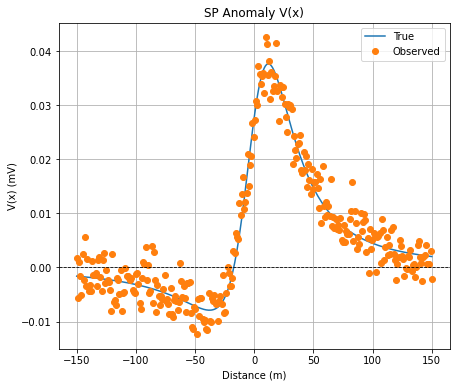

In [3]:
h = 30  # Depth (m)
theta_deg = 30  # Angle in degrees
theta_rad = np.radians(theta_deg) # Angle in radians
K = 50  # SP coefficient (mV)
q = 1.5  # Shape factor for a sphere

x_vals = np.linspace(-150, 150, 300)  # Profile along 300m (x-coordinates)
theta_true = np.array([K,theta_rad,h,q]) # Model Parameters
V_true = forward(x_vals, theta_true)

# Add noise to data
sigma = 3e-3
noise = np.random.normal(0, sigma, len(x_vals))
V_obs = V_true + noise

# Plotting the SP anomaly
plt.figure(figsize=(7, 6))
plt.plot(x_vals, V_true,"-",label="True")
plt.plot(x_vals, V_obs,"o",label="Observed")
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.title("SP Anomaly V(x)")
plt.xlabel("Distance (m)")
plt.ylabel("V(x) (mV)")
plt.legend()
plt.grid()
plt.show()

In [4]:
x_vals.shape

(300,)

In [5]:
# Initialize MCMC object
mcstat = MCMC()

# Create the dataset
ndp = V_obs.shape[0]
x = x_vals
x = x.reshape(ndp, 1) # enforce column vector
y = V_obs
y = y.reshape(ndp, 1) # enforce column vector

# data structure 
mcstat.data.add_data_set(x,y)

In [6]:
x.shape

(300, 1)

In [7]:
# define the sum of squared function for objective
def objective(theta, data):
    res = data.ydata[0] - forward(data.xdata[0], theta)
    return (res**2).sum(axis=0)

In [8]:
# Perform Least Square Inversion [Deterministic]
import scipy
def residuals(p, x, y):
    return y - forward(x, p)

theta0, ssmin = scipy.optimize.leastsq(
    residuals,
    x0=[45,np.radians(20),45,2],
    args=(mcstat.data.xdata[0].reshape(ndp,),
          mcstat.data.ydata[0].reshape(ndp,)))
n = mcstat.data.n[0] # number of data points in model
p = len(theta0); # number of model parameters (dof)
ssmin = objective(theta0, mcstat.data) # calculate the sum-of-squares error
mse = ssmin/(n-p) # estimate for the error variance

print(f"No. data points: {n}")
print(f"No. model parameters: {p}")
print(f"The sum of squares error for the optimal parameters: {ssmin[0]}")
print(f"The error variance estimate: {mse[0]}")
print(f"The optimal value of the parameters: {theta0}")

No. data points: 300
No. model parameters: 4
The sum of squares error for the optimal parameters: 0.002455803103288455
The error variance estimate: 8.29663210570424e-06
The optimal value of the parameters: [95.18561998  0.51506698 32.68054975  1.56861735]


C:\Users\shrut\anaconda3\envs\venv3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [9]:
# Define the model parameters [in the right order] and their initial guesses
mcstat.parameters.add_model_parameter(name='K', theta0=47, minimum=40, maximum=60)
mcstat.parameters.add_model_parameter(name='theta_rad', theta0=np.radians(20), minimum=np.radians(10), maximum=np.radians(40))
mcstat.parameters.add_model_parameter(name='h', theta0=20.0, minimum=15, maximum=45)
mcstat.parameters.add_model_parameter(name='q', theta0=2.0, minimum=1.0, maximum=3.0)

In [10]:
# Update the simulation hyperparameters
mcstat.simulation_options.define_simulation_options(
    nsimu=5e3, # number of simulation steps
    updatesigma=True, # set update sigma to true
    qcov=np.eye(p), # the initial covariance matrix [we keep it identity]
    method = "dram") # am, dram, mh, dr methods available

mcstat.model_settings.define_model_settings(sos_function=objective, sigma2=(3e-2)**2) 

In [11]:
mcstat.run_simulation()


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
         K:     47.00 [    40.00,     60.00] N( 0.00e+00,      inf)
 theta_rad:      0.35 [     0.17,      0.70] N( 0.00e+00,      inf)
         h:     20.00 [    15.00,     45.00] N( 0.00e+00,      inf)
         q:      2.00 [     1.00,      3.00] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 5000 of 5000 complete in 4.6 sec

In [12]:
# Display the chain statistics
results = mcstat.simulation_results.results
names = results['names']
chain = results['chain']
s2chain = results['s2chain']
names = results['names'] # parameter names
mcstat.chainstats(chain, results)



------------------------------
      name:      mean       std    MC_err       tau    geweke
         K:     46.64      1.46      0.27    233.93      1.00
 theta_rad:      0.54      0.02  2.71e-03     97.19      0.95
         h:     30.15      2.28      0.49    272.97      0.68
         q:      1.49      0.03  5.03e-03    231.88      0.94
------------------------------
Acceptance rate information
---------------
Results dictionary:
Stage 1: 1.72%
Stage 2: 25.78%
Net    : 27.50% -> 1375/5000
---------------
Chain provided:
Net    : 27.50% -> 1375/5000
---------------
Note, the net acceptance rate from the results dictionary
may be different if you only provided a subset of the chain,
e.g., removed the first part for burnin-in.
------------------------------


In [13]:
results['parind']


array([0, 1, 2, 3], dtype=int64)

In [14]:
q = results['theta']
q

array([50.5222373 ,  0.53550685, 31.58391137,  1.49266758])

In [15]:
l=np.array([10, 20, 30, 40])
for a,b in enumerate(l):
    print(a,b)

0 10
1 20
2 30
3 40


In [16]:
s2chain

array([[9.00000000e-04],
       [1.76897028e-04],
       [1.51557279e-04],
       ...,
       [1.11263050e-05],
       [1.03862164e-05],
       [1.04352364e-05]])

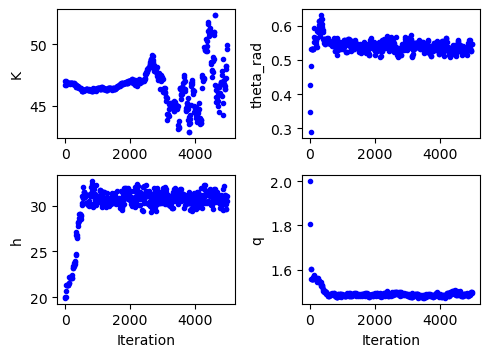

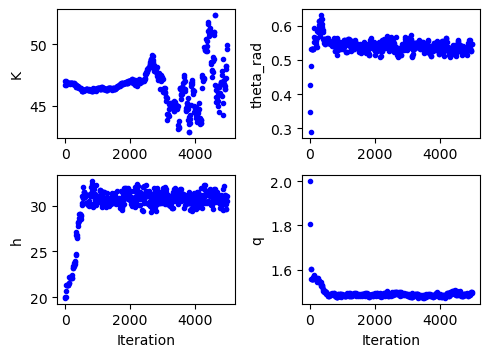

In [17]:
from pymcmcstat import mcmcplot as mcp

# plot chain panel
mcp.plot_chain_panel(chain, names)

In [19]:

from scipy.stats import norm



In [20]:
print(f"True values of thetas: {theta_true}")
print(f"Predicted mean values of thetas: {np.mean(chain, axis=0)}")
print(f"RMSE value of the forward modelled response: {np.sqrt(np.mean((V_true-forward(x_vals,np.mean(chain, axis=0)))**2))}")

True values of thetas: [50.          0.52359878 30.          1.5       ]
Predicted mean values of thetas: [46.63576298  0.54023057 30.15260222  1.49329947]
RMSE value of the forward modelled response: 0.00034438502616823745


Generating credible/prediction intervals:


Interval generation complete



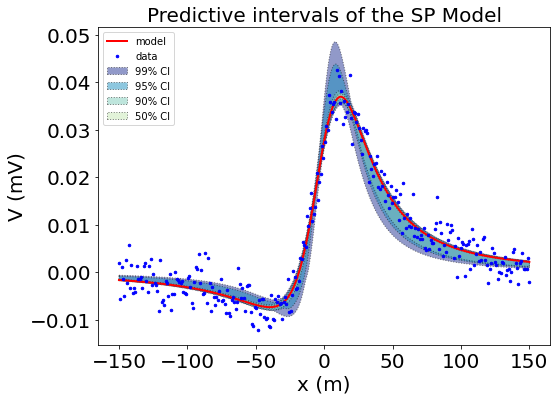

In [22]:
# Prediction model function
def predposterior(data, theta):
    return forward(data.xdata[0], theta)

# Setup prediction interval calculation
mcstat.PI.setup_prediction_interval_calculation(
    results=results,
    data=mcstat.data,
    modelfunction=predposterior
)

# Generate prediction intervals
mcstat.PI.generate_prediction_intervals(
    nsample=500,         # Number of samples from the posterior
    calc_pred_int=False  # Do not calculate predictive intervals
)

# Plot prediction intervals
mcstat.PI.plot_prediction_intervals(adddata=True)
plt.xlabel('x (m)', fontsize=20)  # Adjusted for SP model units
plt.xticks(fontsize=20)
plt.ylabel('V (mV)', fontsize=20)  # Adjusted for SP model units
plt.yticks(fontsize=20)
plt.title('Predictive intervals of the SP Model', fontsize=20)
plt.show()

In [23]:


# Extract parameter samples from the chain
parameter_names = results['names']  # Parameter names (e.g., ['K', 'theta_rad', 'h', 'q'])


# Function to compute credible intervals
def compute_credible_intervals(chain, ci_levels=[0.50, 0.75, 0.95]):
    credible_intervals = {}
    for i, param in enumerate(parameter_names):
        samples = chain[:, i]  # Extract samples for the parameter
        credible_intervals[param] = {}
        for ci in ci_levels:
            lower_bound = np.percentile(samples, (1 - ci) / 2 * 100)
            upper_bound = np.percentile(samples, (1 + ci) / 2 * 100)
            credible_intervals[param][f'{int(ci * 100)}%'] = (lower_bound, upper_bound)
    return credible_intervals

# Compute credible intervals for parameters
credible_intervals = compute_credible_intervals(chain)

# Display results
print("Credible Intervals for Model Parameters:")
for param, intervals in credible_intervals.items():
    print(f"Parameter: {param}")
    for ci, bounds in intervals.items():
        print(f"  {ci} credible interval: {bounds}")


Credible Intervals for Model Parameters:
Parameter: K
  50% credible interval: (46.234928154590406, 47.029863442449916)
  75% credible interval: (45.035703634799525, 47.900546746400295)
  95% credible interval: (43.72772135084315, 50.86838347308438)
Parameter: theta_rad
  50% credible interval: (0.5302196339025845, 0.5493975223404937)
  75% credible interval: (0.5235666993889583, 0.5578566481111673)
  95% credible interval: (0.5120431717068928, 0.5869404784811829)
Parameter: h
  50% credible interval: (30.21045299153392, 31.176308979416998)
  75% credible interval: (29.643528320321654, 31.502511073339853)
  95% credible interval: (21.607553425046635, 32.11705649948823)
Parameter: q
  50% credible interval: (1.483229679792666, 1.492035677274352)
  75% credible interval: (1.4806511643698776, 1.4981731635030204)
  95% credible interval: (1.4757470892590536, 1.5620114241802792)


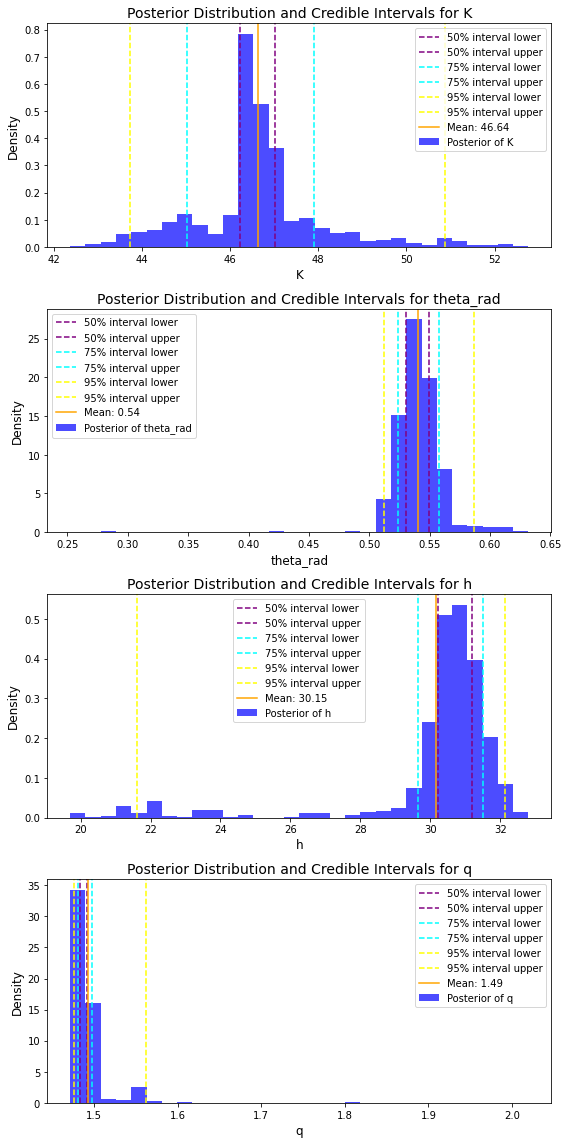

In [24]:

def plot_credible_intervals(chain, parameter_names, credible_intervals, bins=30):
    """
    Plots histograms of parameter samples with mean and credible intervals.
    
    Args:
        chain (np.ndarray): MCMC chain with shape (samples, parameters).
        parameter_names (list): Names of parameters corresponding to columns in the chain.
        credible_intervals (dict): Credible intervals for each parameter, with levels as keys.
        bins (int): Number of bins for the histogram.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    num_params = len(parameter_names)
    fig, axes = plt.subplots(num_params, 1, figsize=(8, 4 * num_params))

    if num_params == 1:  # Handle single parameter case
        axes = [axes]

    # Define colors for different credible intervals
    interval_colors = {
        "50%": "purple",
        "75%": "cyan",
        "95%": "yellow"
    }

    for i, param in enumerate(parameter_names):
        ax = axes[i]
        samples = chain[:, i]

        # Compute the mean of the parameter
        mean = np.mean(samples)

        # Plot histogram
        ax.hist(samples, bins=bins, density=True, alpha=0.7, color='blue', label=f'Posterior of {param}')

        # Add credible intervals
        for ci, bounds in credible_intervals[param].items():
            color = interval_colors.get(ci, "black")  # Default to black if ci not in interval_colors
            ax.axvline(bounds[0], color=color, linestyle='--', label=f'{ci} interval lower')
            ax.axvline(bounds[1], color=color, linestyle='--', label=f'{ci} interval upper')

        # Add mean
        ax.axvline(mean, color='orange', linestyle='-', label=f'Mean: {mean:.2f}')

        # Customize plot
        ax.set_title(f'Posterior Distribution and Credible Intervals for {param}', fontsize=14)
        ax.set_xlabel(f'{param}', fontsize=12)
        ax.set_ylabel('Density', fontsize=12)
        ax.legend()

    plt.tight_layout()
    plt.show()








# Call the function to plot
plot_credible_intervals(chain, parameter_names, credible_intervals)


In [25]:
import numpy as np
import sys

# Function to check and adjust the size of s2chain (noise variance)
def check_s2chain(s2chain, nsimu):
    # If s2chain is a single number, make it an array of that number repeated nsimu times
    if isinstance(s2chain, float):
        s2chain = np.ones(nsimu) * s2chain
    # If s2chain is a 2D array but doesn't match nsimu, adjust its size
    if s2chain.ndim == 2 and s2chain.shape[0] != nsimu:
        s2chain = s2chain * np.ones((nsimu, s2chain.size))
    # If s2chain is a 1D array but doesn't match nsimu, adjust its size
    elif s2chain.size != nsimu:
        s2chain = s2chain * np.ones((nsimu, s2chain.size))
    return s2chain

# Function to add noise (observation errors) to model predictions
def observation_sample(s2, y, sstype):
    if sstype == 0:  # Additive noise (just add random noise)
        return y + np.random.standard_normal(y.shape) * np.sqrt(s2)
    elif sstype == 1:  # Square root transformation (add noise to the square root of y)
        return (np.sqrt(y) + np.random.standard_normal(y.shape) * np.sqrt(s2))**2
    elif sstype == 2:  # Log transformation (add noise to the log of y)
        return y * np.exp(np.random.standard_normal(y.shape) * np.sqrt(s2))
    else:
        sys.exit('Unknown sstype')  # Exit if sstype is not recognized

# Function to calculate credible and prediction intervals
def calculate_intervals(chain, results, data, model, s2chain=None, nsample=500, sstype=0):
    parind = results['parind']  # Indices of parameters in the chain
    q = results['theta']  # Current parameter values
    nsimu, npar = chain.shape  # Number of simulations and parameters
    s2chain = check_s2chain(s2chain, nsimu)  # Adjust s2chain size if needed
    iisample = np.random.choice(nsimu, nsample, replace=False)  # Randomly sample points from the chain

    ci, pi = [], []  # Lists to store credible and prediction intervals
    for isa in iisample:
        q[parind] = chain[isa, :]  # Update parameters with values from the chain
        y = model(data, q)  # Evaluate the model (forward function) with these parameters
        ci.append(y)  # Store the credible interval
        if s2chain is not None:  # If s2chain is provided, calculate prediction interval
            pi.append(observation_sample(s2chain[isa], y, sstype))  # Add noise to the prediction
    
    credible = np.array(ci)  # Convert credible intervals to a numpy array
    prediction = np.array(pi) if s2chain is not None else None  # Convert prediction intervals if they exist
    return dict(credible=credible, prediction=prediction)


# Example usage
# chain = ... (your MCMC chain)
# results = ... (your results dictionary)
# x_vals = ... (your input data)
# s2chain = ... (your noise variance)

# Calculate intervals
intervals = calculate_intervals(chain, results, x_vals, forward, s2chain=s2chain, nsample=500)

# Output results
print("Credible Intervals Shape:", intervals['credible'].shape)
print("Prediction Intervals Shape:", intervals['prediction'].shape)

Credible Intervals Shape: (500, 300)
Prediction Intervals Shape: (500, 300)


In [26]:
type(results)

dict


Credible Intervals (95%):
Point 1: [-0.0018, -0.0008]
Point 2: [-0.0018, -0.0009]
Point 3: [-0.0019, -0.0009]
Point 4: [-0.0019, -0.0009]
Point 5: [-0.0019, -0.0009]
Point 6: [-0.0019, -0.0009]
Point 7: [-0.0019, -0.0009]
Point 8: [-0.0020, -0.0009]
Point 9: [-0.0020, -0.0009]
Point 10: [-0.0020, -0.0010]
Point 11: [-0.0020, -0.0010]
Point 12: [-0.0021, -0.0010]
Point 13: [-0.0021, -0.0010]
Point 14: [-0.0021, -0.0010]
Point 15: [-0.0021, -0.0010]
Point 16: [-0.0022, -0.0010]
Point 17: [-0.0022, -0.0011]
Point 18: [-0.0022, -0.0011]
Point 19: [-0.0022, -0.0011]
Point 20: [-0.0023, -0.0011]
Point 21: [-0.0023, -0.0011]
Point 22: [-0.0023, -0.0011]
Point 23: [-0.0024, -0.0012]
Point 24: [-0.0024, -0.0012]
Point 25: [-0.0024, -0.0012]
Point 26: [-0.0025, -0.0012]
Point 27: [-0.0025, -0.0012]
Point 28: [-0.0025, -0.0012]
Point 29: [-0.0025, -0.0013]
Point 30: [-0.0026, -0.0013]
Point 31: [-0.0026, -0.0013]
Point 32: [-0.0027, -0.0013]
Point 33: [-0.0027, -0.0013]
Point 34: [-0.0027, -0.00


Prediction Intervals (95%):
Point 1: [-0.0082, 0.0055]
Point 2: [-0.0085, 0.0052]
Point 3: [-0.0081, 0.0050]
Point 4: [-0.0088, 0.0056]
Point 5: [-0.0092, 0.0059]
Point 6: [-0.0078, 0.0062]
Point 7: [-0.0081, 0.0050]
Point 8: [-0.0080, 0.0048]
Point 9: [-0.0081, 0.0047]
Point 10: [-0.0098, 0.0049]
Point 11: [-0.0091, 0.0049]
Point 12: [-0.0095, 0.0045]
Point 13: [-0.0089, 0.0055]
Point 14: [-0.0094, 0.0045]
Point 15: [-0.0081, 0.0047]
Point 16: [-0.0094, 0.0055]
Point 17: [-0.0089, 0.0046]
Point 18: [-0.0082, 0.0052]
Point 19: [-0.0087, 0.0041]
Point 20: [-0.0100, 0.0043]
Point 21: [-0.0095, 0.0042]
Point 22: [-0.0090, 0.0050]
Point 23: [-0.0092, 0.0050]
Point 24: [-0.0096, 0.0051]
Point 25: [-0.0088, 0.0055]
Point 26: [-0.0093, 0.0050]
Point 27: [-0.0082, 0.0046]
Point 28: [-0.0090, 0.0054]
Point 29: [-0.0098, 0.0049]
Point 30: [-0.0087, 0.0048]
Point 31: [-0.0084, 0.0054]
Point 32: [-0.0097, 0.0047]
Point 33: [-0.0091, 0.0051]
Point 34: [-0.0088, 0.0042]
Point 35: [-0.0088, 0.0044]


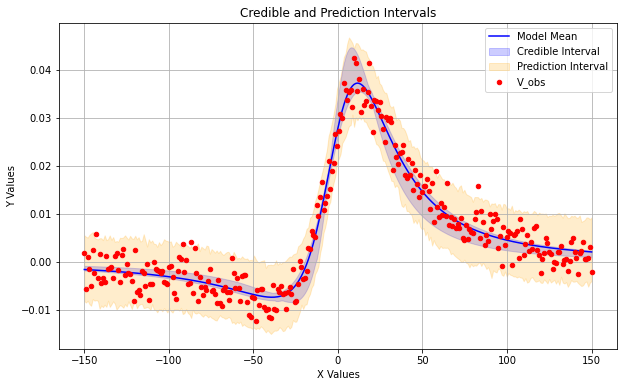

In [27]:

def plot_intervals(x_vals, credible, prediction=None, observed=None):
    # Calculate mean and bounds for credible intervals
    credible_mean = np.mean(credible, axis=0)
    credible_lower = np.percentile(credible, 2.5, axis=0)
    credible_upper = np.percentile(credible, 97.5, axis=0)

    # Print credible intervals
    print("\nCredible Intervals (95%):")
    for i, (lo, hi) in enumerate(zip(credible_lower, credible_upper)):
        print(f"Point {i+1}: [{lo:.4f}, {hi:.4f}]")

    # Plot credible intervals
    plt.figure(figsize=(10, 6))
    plt.fill_between(x_vals, credible_lower, credible_upper, color='blue', alpha=0.2, label='Credible Interval')
    plt.plot(x_vals, credible_mean, color='blue', label='Model Mean')

    # If prediction intervals are available, calculate and plot them
    if prediction is not None:
        prediction_lower = np.percentile(prediction, 2.5, axis=0)
        prediction_upper = np.percentile(prediction, 97.5, axis=0)
        plt.fill_between(x_vals, prediction_lower, prediction_upper, color='orange', alpha=0.2, label='Prediction Interval')

        # Print prediction intervals
        print("\nPrediction Intervals (95%):")
        for i, (lo, hi) in enumerate(zip(prediction_lower, prediction_upper)):
            print(f"Point {i+1}: [{lo:.4f}, {hi:.4f}]")

    # If observed values are provided, plot them
    if observed is not None:
        plt.scatter(x_vals, observed, color='red', label='V_obs', zorder=5, s=20)  # Reduced scatter size

    # Configure plot
    plt.xlabel('X Values')
    plt.ylabel('Y Values')
    plt.title('Credible and Prediction Intervals')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the plotting function with your data
plot_intervals(x_vals, intervals['credible'], prediction=intervals['prediction'], observed=V_obs)
